In [58]:
#imports
import scipy as sp
import math
import numpy as np

import pprint  as pp
import matplotlib.pyplot as plt
from functools import partial
from ipywidgets import interact,widgets




### Set up constants 

In [8]:
#given params:
#E
c_Ena       = 45
c_Ek        =-80
c_El        =-59
#g
c_gna_bar    = 120
c_gk_bar     = 36
c_gl        = 0.3
#C (cap membrana)
c_C         = 1

### define functions for ease of handling and extensibility
*note this is pm the same as lab 2 so reusing ALL the code*

In [42]:
#diffs
#signature>> t , V , n , m , h , Ix, Cm , g , E 
f_dVdt = lambda t , V , n , m , h , Ix, Cm , g , E : (Ix - g(V,n,m,h) * ( V - E(V,n,m,h) ) ) / Cm
#channel diff eqs:******************
f_dndt = lambda t , V , n , alpha_n , beta_n :  alpha_n(V) * (1-n) - beta_n(V) * n #k+
f_dmdt = lambda t , V , m , alpha_m , beta_m :  alpha_m(V) * (1-m) - beta_m(V) * m #Na+ ap
f_dhdt = lambda t , V , h , alpha_h , beta_h :  alpha_h(V) * (1-h) - beta_h(V) * h #Na+ cl
#************************************

#alpha|beta -> m -> g_i -> g -> E
f_alpha_n = lambda V : ( V + 60 )   /   ( 100 * (1 - np.exp (-(V+60)/10) )  )
f_alpha_m = lambda V : ( V + 45 )   /   ( 10 * (1 - np.exp (-(V+45)/10) ) )
f_alpha_h = lambda V : ( 0.07 * np.exp (-( V + 70) / 20) ) 

f_beta_n  = lambda V : 0.125 * np.exp (   - (V+70) / 80 )     
f_beta_m  = lambda V : 4     * np.exp (   - (V+70) / 10 ) #  18 )   
f_beta_h  = lambda V : 1 / ( 1 + np.exp ( - (V+40) / 10  ) )

#f_m     = lambda V , alpha_m , beta_m : alpha_m(V) / (alpha_m(V) + beta_m(V) ) ahora es eq diff 7w7

f_gna   = lambda V , m , h , gna_bar    : gna_bar * m**3 * h
f_gk    = lambda V , n , gk_bar         : gk_bar  * n**4
f_gl    = lambda *_ : c_gl
f_g     = lambda V , n , m , h , gna , gk , gl: gna(V,m,h) + gk(V,n) + gl() # Na (m,h) + K (n) + leak
f_E     = lambda V , n , m , h , Ena, Ek, El, gna, gk , gl : np.average([Ena, Ek, El],weights=[gna(V,m,h),gk(V,n),gl()])


In [6]:
f_test = lambda *_ : 5
print(f_test(1,2,3), f_test(), f_test(1))

5 5 5


## Note que esta vez el problema de valor inicial tiene más variables:
- tiempo
- voltaje
- n (canales ab de potasio) 
- m (canales ab de sodio ap) 
- h (canales ab de sodio cl) 
##### en el lab anterior había par ecs diff. en este hay un sistema de 4 ecs. diff:
$$\left\{ \frac{dV}{dt} , \frac{dn}{dt} , \frac{dm}{dt}, \frac{dh}{dt} ; t,v,n,m,h \right\}
$$


### Partially evaluate functions with given constants:

In [43]:

#fp_m    =  partial ( f_m , alpha_m = f_alpha_m , beta_m = f_beta_m )

fp_gna  = partial ( f_gna , gna_bar = c_gna_bar) #, m = fp_m )
fp_gk   = partial ( f_gk , gk_bar = c_gk_bar )
#fp_gl x as f_gl is just leak or whatever nb cares

fp_g    = partial (f_g , gna = fp_gna , gk = fp_gk , gl = f_gl) 

fp_E    = partial (f_E, Ena = c_Ena , Ek = c_Ek, El= c_El, gna = fp_gna, gk = fp_gk , gl = f_gl )

#signature>> t , V , n , m , h , Ix, Cm , g , E 
fp_dVdt = partial(  f_dVdt ,     
#                        Ix  = p_Ix    ,
                        Cm  = c_C     , 
                        g   = fp_g    ,
                        E   = fp_E  )

#dndt signature:: t , V , n , alpha_n , beta_n 
fp_dndt = partial(  f_dndt , 
                        alpha_n=f_alpha_n , 
                        beta_n=f_beta_n )
fp_dmdt = partial(  f_dmdt , 
                        alpha_m=f_alpha_m , 
                        beta_m=f_beta_m )
fp_dhdt = partial(  f_dhdt , 
                        alpha_h=f_alpha_h , 
                        beta_h=f_beta_h )




## Sacar el dibujito:
- primero con interact (q no sé si funciona? me avisan)
- abajo sin interact, q además saca dibujos bien bonis

In [75]:
#p_Ix =  25 #mA ?
#iv_v = -50
#iv_n = 0.1

# y0 = V, y1 = n, y2 = m , y3 = h

def_I   = 0.0
def_V   = -75
def_n   = 0.0
def_m   = 0.1
def_h   = 0.9
def_tM  = 50


@interact(      Ix       =   (  -50   , 75.0  ,  0.05 ), 
                iv_v     =   ( -100  , 34    ,  0.01) , 
                iv_n     =   (  0   , 1     ,  0.001) , 
                iv_m     =   (  0   , 1     ,  0.001) , 
                iv_h     =   (  0   , 1     ,  0.001) , 
                span_M   =   (  -69   , 100    ,  1) )
def plotFunc( Ix = 0.0 , iv_v = -75 , iv_n = 0.1 , iv_m = 0.0 , iv_h =0.9 , span_M=50):
    span_t = ( min(0,span_M) , max(0,span_M) )

    fpp_dVdt = partial(fp_dVdt , Ix = Ix )

    simpleNeuron = lambda t , y : ( fpp_dVdt( t=t , V = y[0] , n = y[1] , m = y[2] , h = y[3] ) , 
                                    fp_dndt ( t , y[0] , y[1]               ) ,
                                    fp_dmdt ( t , y[0] ,        y[2]        ) ,
                                    fp_dhdt ( t , y[0] ,               y[3] )
                                    )
                                    

    #print(simpleNeuron(0, [iv_v , iv_n , iv_m , iv_h ]))
    sol = sp.integrate.solve_ivp(simpleNeuron , span_t , (iv_v , iv_n , iv_m , iv_h) , method='LSODA' ) 
    plt.plot(sol.t,sol.y[0])
 

interactive(children=(FloatSlider(value=0.0, description='Ix', max=75.0, min=-50.0, step=0.05), FloatSlider(va…

0: 0.000 	->	-50.000 	
77: 1.914 	->	-2.728 	
154: 10.625 	->	-46.186 	
231: 13.332 	->	-24.542 	
308: 20.750 	->	-10.885 	
385: 23.934 	->	-63.631 	
462: 30.908 	->	39.180 	
539: 34.488 	->	-77.738 	
616: 41.143 	->	34.573 	
694: 50.000 	->	-64.971 	


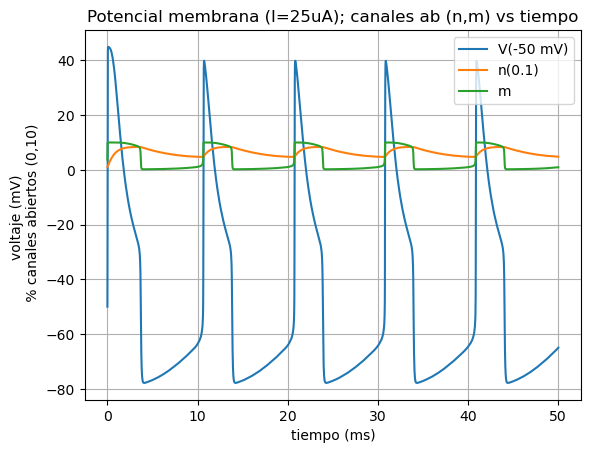

In [6]:
p_Ix = 25 #mA ?
iv_v = -50
iv_n = 0.1
span_M = 50 # ms
# y0 = V, y1 = n
#@interact(Ix = (0,50.0,0.05), iv_v = (-10,10,0.01) , iv_n = (0,1,0.001) , span_M = (0,10,0.1) )
span_t = ( 0 , span_M )
fpp_dVdt = partial(fp_dVdt , Ix =p_Ix )
simpleNeuron = lambda t , y : ( fpp_dVdt( t=t , V = y[0] , n = y[1] , m = y[2] , h = y[3] ) , 
                                    fp_dndt ( t , y[0] , y[1]               ) ,
                                    fp_dmdt ( t , y[0] ,        y[2]        ) ,
                                    fp_dhdt ( t , y[0] ,               y[3] )
                                    )
    

sol = sp.integrate.solve_ivp(simpleNeuron , span_t , [iv_v, iv_n] , method='LSODA', dense_output=True )
plt.plot(sol.t,sol.y[0])
#plt.show()
plt.plot(sol.t , 10*sol.y[1])
plt.plot(sol.t , list(map(lambda x: 10* fp_m(x) , sol.y[0]) ) )
plt.legend(["V({vi} mV)".format(vi=iv_v), "n({ni})".format(ni=iv_n), "m"], loc= 1)
plt.title("Potencial membrana (I={Iin:2f}uA) ; canales ab (n,m,h) vs tiempo".format(Iin=p_Ix) )
plt.xlabel("tiempo (ms)")
plt.ylabel("voltaje (mV) \n % canales abiertos (0,10)")
#plt.axhline(y=0)
plt.grid(visible=True)
#plt.savefig("out_vnm_i{ix}.png".format(ix = p_Ix))

template = "{p}: {t:2.3f} \t->\t{v:2.3f} \t"
sample = np.linspace(0,len(sol.t)-1 , 10 , dtype=int)
for s in sample:
    print(template.format(p=s,t= sol.t[s] , v=sol.y[0][s] ) )

#### lo de abajo solo es para sacar el dibujo con varios valores de Ix.


In [7]:

#map eval
p_Ixr = np.linspace(0,50,5)
sols = map( partial(sp.integrate.solve_ivp, t_span=span_t, y0 = [iv_v,iv_n], method='LSODA' ) ,
        map( lambda f : (lambda t,y :(f ( t , y[0],y[1] ) , fp_dndt( t,y[0],y[1] )  )  ) , 
                map( lambda x : partial(fp_dVdt , Ix= x ) , 
                    p_Ixr ) 
        )
    )
def plotF (s):
    plt.plot( s.t , s.y[0] ) #"Ix = {val}".format(val = s[0]) )
    plt.legend(p_Ixr)
plt.title("V vs t;  variando I ext.")
z = [*map(plotF,sols)]
plt.savefig("out.png")
plt.close()